## Attempt at Pseudo Labeling with XGBClassifier for Season 3, EP 7

##### Referencing notebooks where insights and ideas have been gathered:
- https://www.kaggle.com/code/cdeotte/pseudo-labeling-qda-0-969
- https://www.kaggle.com/code/sergiosaharovskiy/ps-s3e7-2023-eda-and-submission
- https://www.kaggle.com/code/martynovandrey/ps-3-7-eda-cv-weights-optimizer
- https://www.kaggle.com/code/alexandershumilin/ps-s3-e7-ensemble-model
- https://www.kaggle.com/code/icfoer/ps6e7-xgboost-leak
- https://www.kaggle.com/code/jcaliz/ps-s03e07-a-complete-eda

I conducted an experiment to test a new approach I recently read about, but unfortunately, it did not yield better results than my previous attempts. I tried four different versions, and the best among them was version 2, which scored 0.92391. However, it was not as good as my attempt using an ensemble model with XGB/RFC, which scored 0.92831. Despite this, I believe it's worth trying this approach in various scenarios as it may produce good results in different contexts. I wonder how these scores will result in the private leaderboard, as the cross-validation scores improved significantly (perhaps overfitting?). For the final submission, I have chosen version 2 using this approach and will keep my (original) previous score of 0.92381.

There is a possibility that a different model or ensemble approach might result in a good private score, but it's hard to say for sure. However, based on the results of trying four different versions, it can be concluded that this approach may not be the best for predicting reservation cancellation (haha).

**LB SCORES with Pseudo Labeling:**
- V1 LB : 0.92386
- V2 LB : 0.92391 
- V3 LB : 0.92383
- V4 LB : 0.92382

In [933]:
import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from datetime import timedelta

from sklearn.metrics import roc_curve, auc, f1_score, confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.utils import shuffle
from sklearn.base import clone
from sklearn.feature_selection import VarianceThreshold

from xgboost import XGBClassifier
from sklearn.calibration import CalibratedClassifierCV

import warnings
warnings.filterwarnings("ignore")

# set display options to show all columns
pd.set_option('display.max_columns', None)

import random

## Functions

In [934]:
def stratified_kfold_train_and_evaluate(X, y, model, predict_test, n_splits=5, predict=True, save_holdout=False, holdout_size=0.2):
    # Instantiate StratifiedKFold class
    skf = StratifiedKFold(n_splits=n_splits, random_state=42, shuffle=True)
    # Initialise lists to hold true positive rates and AUC scores for each fold
    tprs = []
    aucs = []
    # Create a mean false positive rate array to evaluate performance
    mean_fpr = np.linspace(0, 1, 100)
    # Initialise a 2x2 confusion matrix to keep track of true/false positives/negatives
    conf_mat = np.zeros((2, 2))
    
    holdout_random_state = random.sample(range(1, 1001), 100)
    choice = random.choice(holdout_random_state)

    # Split data into training and holdout sets
    if save_holdout:
        if fold_random_states is not None:
            holdout_random_state = fold_random_states[-1]
            train_random_states = fold_random_states[:-1]
        else:
            holdout_random_state = random_state
            train_random_states = [random_state] * n_splits
        X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=holdout_size, random_state=choice)
    else:
        X_train, y_train = X, y

    # Loop over each fold in the StratifiedKFold object
    for i, (train, test) in enumerate(skf.split(X_train, y_train)):
        # Split data into training and test sets
        X_train_fold, X_test = X_train.iloc[train], X_train.iloc[test]
        y_train_fold, y_test = y_train.iloc[train], y_train.iloc[test]

        # Train the model
        model.fit(X_train_fold, y_train_fold)

    # Create a new figure and axis to plot results
    fig, ax = plt.subplots()

    # Loop over each fold in the StratifiedKFold object
    for i, (train, test) in enumerate(skf.split(X_train, y_train)):
        print(f'Fold {i + 1}')
        # Split data into training and test sets
        X_train_fold, X_test = X_train.iloc[train], X_train.iloc[test]
        y_train_fold, y_test = y_train.iloc[train], y_train.iloc[test]

        # Train the model
        model.fit(X_train_fold, y_train_fold)

        # Predict the probabilities of the test set and calculate the ROC curve
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        # Plot the ROC curve for each fold
        plt.plot(fpr, tpr, lw=1, alpha=0.3, label=f'Fold {i+1} (AUC = {roc_auc:.2f})')
        print(f'  AUC: {roc_auc:.4f}')

        # Use the trained model to predict on the test set
        y_pred = model.predict(X_test)
        # Add the resulting confusion matrix to the total confusion matrix
        conf_mat += confusion_matrix(y_test, y_pred, labels=[0, 1])

    # Calculate the mean true positive rate and AUC across all folds
    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = round(auc(mean_fpr, mean_tpr),4)
    std_auc = np.std(aucs)
    # Plot the mean ROC curve
    plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean (AUC = {mean_auc:.2f} $\pm$ {std_auc:.2f})', lw=2, alpha=.8)

    # Add a line for a random classifier
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random', alpha=.8)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    if save_holdout:
        # Train the model on the full training dataset and predict on the holdout set
        model.fit(X_train, y_train)
        y_holdout_pred_proba = model.predict_proba(X_holdout)[:, 1]
        holdout_fpr, holdout_tpr, holdout_thresholds = roc_curve(y_holdout, y_holdout_pred_proba)
        holdout_auc = round(auc(holdout_fpr, holdout_tpr), 4)
        print(f'Holdout AUC score: {holdout_auc}')

    if predict:
        # Use the trained model to predict on the given test dataset
        model.fit(X, y)
        y_test_prob = model.predict_proba(predict_test)[:, 1]

        return y_test_prob


In [935]:
def return_csv():
    train = pd.read_csv('/kaggle/input/playground-series-s3e7/train.csv')
    test = pd.read_csv('/kaggle/input/playground-series-s3e7/test.csv')
    additional_train = pd.read_csv('/kaggle/input/reservation-cancellation-prediction/train__dataset.csv')
    additional_test = pd.read_csv('/kaggle/input/reservation-cancellation-prediction/test___dataset.csv')
    
    return train, test, additional_train, additional_test

def process_data(df):
    # Create derived features - https://www.kaggle.com/code/martynovandrey/ps-3-7-eda-cv-weights-optimizer
    df['nights'] = df['no_of_weekend_nights'] + df['no_of_week_nights']
    df['lead_x_nights'] = df['lead_time'] * df['nights']
    df['arrival'] = pd.to_datetime(df['arrival_year'].astype(str) + "/" + df['arrival_month'].astype(str) + "/" + df['arrival_date'].astype(str), errors='coerce')
    df['arrival'] = df['arrival'].replace(pd.Timestamp('NaT'), pd.to_datetime('2018-02-28'))
    df['booking'] = df['arrival'] - pd.to_timedelta(df['lead_time'], unit='D')
    df['departure'] = df['arrival'] + pd.to_timedelta(df['nights'], unit='D')
    df['room_type_cat'] = df['room_type_reserved'].astype('int')
    
#     # Binning lead_time into categories
#     bins = [-1, 7, 14, 30, 60, np.inf]
#     labels = [0, 1, 2, 3, 4]
#     df['lead_time_cat'] = pd.cut(df['lead_time'], bins=bins, labels=labels)
    
    # Creating categorical variables for previous cancellations and bookings
#     df['prev_cancel_cat'] = pd.cut(df['no_of_previous_cancellations'], bins=[-1, 0, 1, np.inf], labels=[0, 1, 2])
#     df['prev_bookings_cat'] = pd.cut(df['no_of_previous_bookings_not_canceled'], bins=[-1, 0, 1, 2, np.inf], labels=[0, 1, 2, 3])
    
    # Creating dummy variables for room_type_cat and month
    df = pd.get_dummies(df, columns=['room_type_cat', 'arrival_month'], prefix=['room_type', 'month'])
    
#     df['lead_time_cat'] = df['lead_time_cat'].astype('int')
#     df['prev_cancel_cat'] = df['prev_cancel_cat'].astype('int')
#     df['prev_bookings_cat'] = df['prev_bookings_cat'].astype('int')

    return df

def date_transform(train):
    # Extract year, month, day, day of the week, and season
#     train['arrival_year'] = train['arrival'].dt.year
    train['arrival_month'] = train['arrival'].dt.month
#     train['arrival_day'] = train['arrival'].dt.day
    train['arrival_weekday'] = train['arrival'].dt.weekday
    train['arrival_season'] = ((train['arrival'].dt.month % 12 + 3) // 3).astype(int)

#     train['booking_year'] = train['booking'].dt.year
    train['booking_month'] = train['booking'].dt.month
#     train['booking_day'] = train['booking'].dt.day
    train['booking_weekday'] = train['booking'].dt.weekday
    train['booking_season'] = ((train['booking'].dt.month % 12 + 3) // 3).astype(int)

#     train['departure_year'] = train['departure'].dt.year
    train['departure_month'] = train['departure'].dt.month
#     train['departure_day'] = train['departure'].dt.day
    train['departure_weekday'] = train['departure'].dt.weekday
    train['departure_season'] = ((train['departure'].dt.month % 12 + 3) // 3).astype(int)

    # Drop the original datetime columns
    train.drop(['arrival', 'booking', 'departure'], axis=1, inplace=True)

    # Drop other columns that are no longer needed
#     train.drop(['arrival_year', 'booking_year', 'departure_year'], axis=1, inplace=True) # If you want to exclude the year feature from the model.
    return train

def extra_engineering(train):
    conditions = [    
        train['required_car_parking_space'] == 0,
        train['lead_time'] >= 5,
        train['market_segment_type'] == 1,
        train['repeated_guest'] == 0,
        train['no_of_previous_cancellations'] == 0,
        train['no_of_special_requests'] == 0,
        train['lead_x_nights'] >= 6,
        train['lead_time_cat'] == 4,
        train['prev_cancel_cat'] == 0,
        train['prev_bookings_cat'] == 0,
        train['month_1'] == 0
    ]

    extra_features = np.sum(conditions, axis=0)
    train['extra_features'] = extra_features

    return train

## Load Data

In [936]:
train, test, additional_train, _ = return_csv()
train.drop(columns=['id'],axis=1,inplace=True),test.drop(columns=['id'],axis=1,inplace=True)
train, additional_train, test = process_data(train),process_data(additional_train),process_data(test)
train = pd.concat([train,additional_train],axis=0)

In [937]:
# train, test = extra_engineering(train), extra_engineering(test)
train, test = date_transform(train), date_transform(test)

## Train and view performance without Pseudo Labeling

In [938]:
features = [i for i in train.columns if i != 'booking_status']
target = 'booking_status'

In [939]:
xgb_params = {
    'learning_rate': 0.05,
    'max_depth': 4,
    'min_child_weight': 5,
    'subsample': 0.9,
    'colsample_bytree': 0.5,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'seed': 42,
    'n_estimators': 3200,
#     'tree_method': 'gpu_hist',
    'reg_alpha': 0.1, 
    'reg_lambda': 0.1
}

Fold 1
  AUC: 0.9157
Fold 2
  AUC: 0.9146
Fold 3
  AUC: 0.9097
Fold 4
  AUC: 0.9104
Fold 5
  AUC: 0.9101


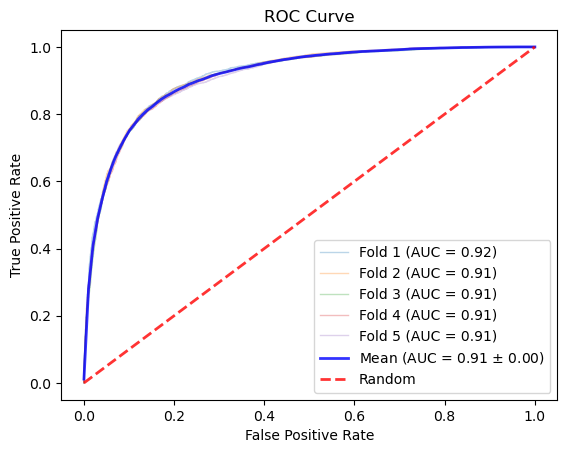

Holdout AUC score: 0.9115


In [940]:
model = XGBClassifier(**xgb_params)
calibrated_model = CalibratedClassifierCV(model, cv=5, method='sigmoid')
stratified_kfold_train_and_evaluate(train[features], train[target], calibrated_model, test, n_splits=5, save_holdout=True, predict=False)

- V1 : Holdout AUC score (without Pseudo Labeling) : 0.9088 
- V2 : Holdout AUC score (without Pseudo Labeling) : 0.9091 - **only changes here was the use of CalibratedClassifierCV**
- V3 : Holdout AUC score (without Pseudo Labeling) : - 
- V4 : Holdout AUC score (without Pseudo Labeling) : 0.9115 - **updated CalibratedClassifierCV to 'sigmoid'**

## Train and view performance with Pseudo Labeling

The paper <a href="https://arxiv.org/pdf/2101.06329.pdf">IN DEFENSE OF PSEUDO-LABELING:
AN UNCERTAINTY-AWARE PSEUDO-LABEL SELECTION FRAMEWORK FOR SEMI-SUPERVISED LEARNING</a> presents a new algorithm called Uncertainty-aware Pseudo-label Selection (UPS) for semi-supervised learning. This method updates the model's parameters using a combination of labeled data and selected pseudo-labeled data, and then selects new pseudo-labeled data based on the updated model. This approach improves the quality of pseudo-labeled data by selecting the most confident samples and discarding unreliable pseudo-labeled samples.

The first function I used implements a simple form of pseudo-labeling. It trains an XGBoost model on the labeled data, makes predictions on the test data, and selects the test samples with high prediction confidence to be added to the training set as pseudo-labeled data. The process is repeated several times to accumulate a larger training set.

The second function below implements a more advanced version of pseudo-labeling, called Uncertainty-aware Pseudo-label Selection (UPS), which uses a more sophisticated method to select high-confidence pseudo-labeled data. The algorithm iteratively updates the model's parameters using a subset of the available labeled data and all of the selected pseudo-labeled data, then selects new pseudo-labeled data based on the updated model. The process is repeated for several iterations to improve the quality of the pseudo-labeled data. The final model is evaluated using k-fold cross-validation.

In [941]:
def uncertainty_pseudolabel(train, test, features, target, uncertainty_threshold=0.995): 
    # Initialise variables
    cols = features
    
    # Train model and predict probabilities for test set
    clf = XGBClassifier(**xgb_params) 
    clf = CalibratedClassifierCV(clf, cv=5, method='sigmoid')
    clf.fit(train[cols], train[target])
    test_probabilities = clf.predict_proba(test[cols])[:, 1]

    # Select test samples that are highly confident
    test_high_confidence = (test_probabilities > uncertainty_threshold) | (test_probabilities < 1 - uncertainty_threshold)
    test_high_confidence_df = test[test_high_confidence].copy()

    # Pseudo-label the highly confident test samples and add to the training set
    test_high_confidence_df[target] = np.where(test_probabilities[test_high_confidence] > 0.5, 1, 0)
    train = pd.concat([train, test_high_confidence_df], axis=0)
    train.reset_index(drop=True, inplace=True)
    
    # Train model on the combined training set and evaluate using k-fold cross validation
    clf.fit(train[cols], train[target])
    for i in range(3):  # perform five iterations of UPS algorithm
        # Predict probabilities for all unlabeled samples
        probabilities = clf.predict_proba(test[cols])[:, 1]

        # Find the top n unlabeled samples with highest predicted probabilities
        n = int(0.2 * len(test))  # select top 20% of unlabeled samples
        indices = np.argsort(probabilities)[-n:]
        new_pseudo_labels = pd.Series(np.where(probabilities[indices] > 0.5, 1, 0), index=indices)

        # Add the new pseudo-labeled samples to the training set
        train = pd.concat([train, test.loc[indices]], axis=0)
        train[target] = train[target].astype('float').fillna(new_pseudo_labels)

        # Train the model on the updated training set
        clf.fit(train[cols], train[target])

    # Evaluate the final model using k-fold cross validation
    prediction = stratified_kfold_train_and_evaluate(train[features], train[target], clf, test, n_splits=10, save_holdout=True, predict=True)

    return prediction

Fold 1
  AUC: 0.9467
Fold 2
  AUC: 0.9460
Fold 3
  AUC: 0.9452
Fold 4
  AUC: 0.9468
Fold 5
  AUC: 0.9465
Fold 6
  AUC: 0.9491
Fold 7
  AUC: 0.9448
Fold 8
  AUC: 0.9511
Fold 9
  AUC: 0.9448
Fold 10
  AUC: 0.9488


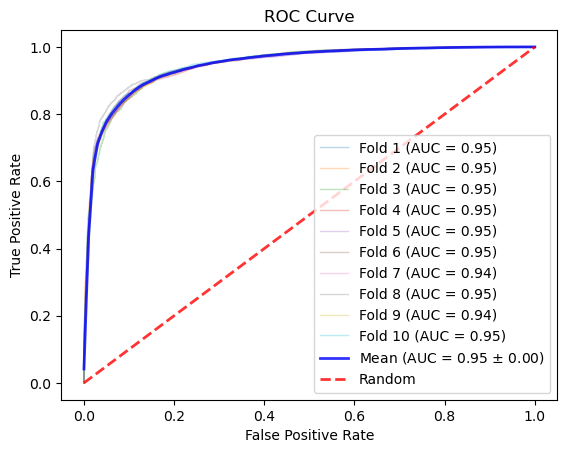

Holdout AUC score: 0.9482


In [942]:
prediction = uncertainty_pseudolabel(train, test, features, target)

- V1 : Holdout AUC score (with Pseudo Labeling) : 0.9167 - **simple form of pseudo-labeling**
- V2 : Holdout AUC score (with Pseudo Labeling) : 0.9589 - **using uncertainty-aware pseudo-label selection (UPS)**
- V3 : Holdout AUC score (with Pseudo Labeling) : 0.9523 - **decreased iterations to 3 and removed CalibratedClassifierCV**
- V4 : Holdout AUC score (with Pseudo Labeling) : 0.9482 - **decreased iterations to 3 and updated CalibratedClassifierCV to 'sigmoid' and uncertainty_threshold to 0.995**

In [943]:
sub = pd.read_csv('/kaggle/input/playground-series-s3e7/sample_submission.csv')
sub.booking_status = prediction
sub.to_csv('submission.csv', index=False)
sub.head(10)

,id,booking_status
0,42100,0.115020
1,42101,0.073820
2,42102,0.215565
3,42103,0.081433
4,42104,0.179017
5,42105,0.951688
6,42106,0.299694
7,42107,0.946291
8,42108,0.068730
9,42109,0.213721


In [944]:
train = pd.read_csv('/kaggle/input/playground-series-s3e7/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s3e7/test.csv')

y = 'booking_status'
dup_features = test.drop(columns='id').columns.tolist()
values_to_assign = test.merge(train.drop(columns='id'), on=dup_features, how='inner')[['id', y]]
map_di = {0: sub[y].max(), 1: sub[y].min()}
sub.loc[sub.id.isin(values_to_assign.id), y] = values_to_assign[y].map(map_di).values
sub.loc[sub.id.isin(values_to_assign.id), y]

sub.to_csv('submission.csv', index=False)
sub.loc[sub.id.isin(values_to_assign.id)].head(10)

,id,booking_status
48,42148,0.068540
92,42192,0.068540
159,42259,0.068540
300,42400,0.068540
319,42419,0.068540
346,42446,0.068540
374,42474,0.966429
429,42529,0.068540
472,42572,0.966429
537,42637,0.966429
